In [1]:
import os

from dotenv import load_dotenv
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download
import matplotlib.pyplot as plt

load_dotenv()
hugging_face_token = os.getenv('HUGGING_FACE_TOKEN')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [14]:
login(
    token=hugging_face_token
)  # login with your User Access Token, found at https://huggingface.co/settings/tokens

local_dir = "/workspaces/stimage/models/uni/assets/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
hf_hub_download("MahmoodLab/UNI",
                filename="pytorch_model.bin",
                local_dir=local_dir,
                force_download=False)
model = timm.create_model("vit_large_patch16_224",
                          img_size=224,
                          patch_size=16,
                          init_values=1e-5,
                          num_classes=0,
                          dynamic_img_size=True)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"),
                                 map_location="cpu"),
                      strict=True)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])
model.eval()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/vscode/.cache/huggingface/token
Login successful


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

In [15]:
image = Image.open("/workspaces/stimage/data/processed/crop/GSE144239_GSM4284317_48x34.png")

In [16]:
image.size

(90, 91)

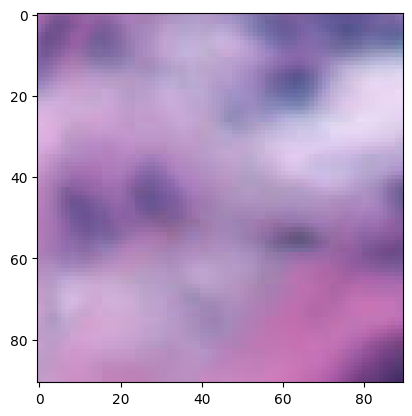

In [17]:
plt.imshow(image)

In [19]:
image = transform(image).unsqueeze(dim=0) # Image (torch.Tensor) with shape [1, 3, 224, 224] following image resizing and normalization (ImageNet parameters)
with torch.inference_mode():
    feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1,1024]

In [20]:
feature_emb.shape

torch.Size([1, 1024])